In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/DS_Case_Study_beer-ratings_2020/train.csv")


In [4]:
# Display basic info
print("Dataset Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSample Data:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthdayRaw   7856 non-null   object 
 16  user

In [5]:
# Drop columns that are irrelevant or have too many missing values
columns_to_drop = [
    'index', 'review/timeStruct', 'review/timeUnix',
    'user/ageInSeconds', 'user/birthdayRaw',
    'user/birthdayUnix', 'user/profileName', 'user/gender'
]
df = df.drop(columns=columns_to_drop)


In [19]:
# Handle missing values
df['beer/ABV'] = df['beer/ABV'].fillna(df['beer/ABV'].median())
data_cleaned = df

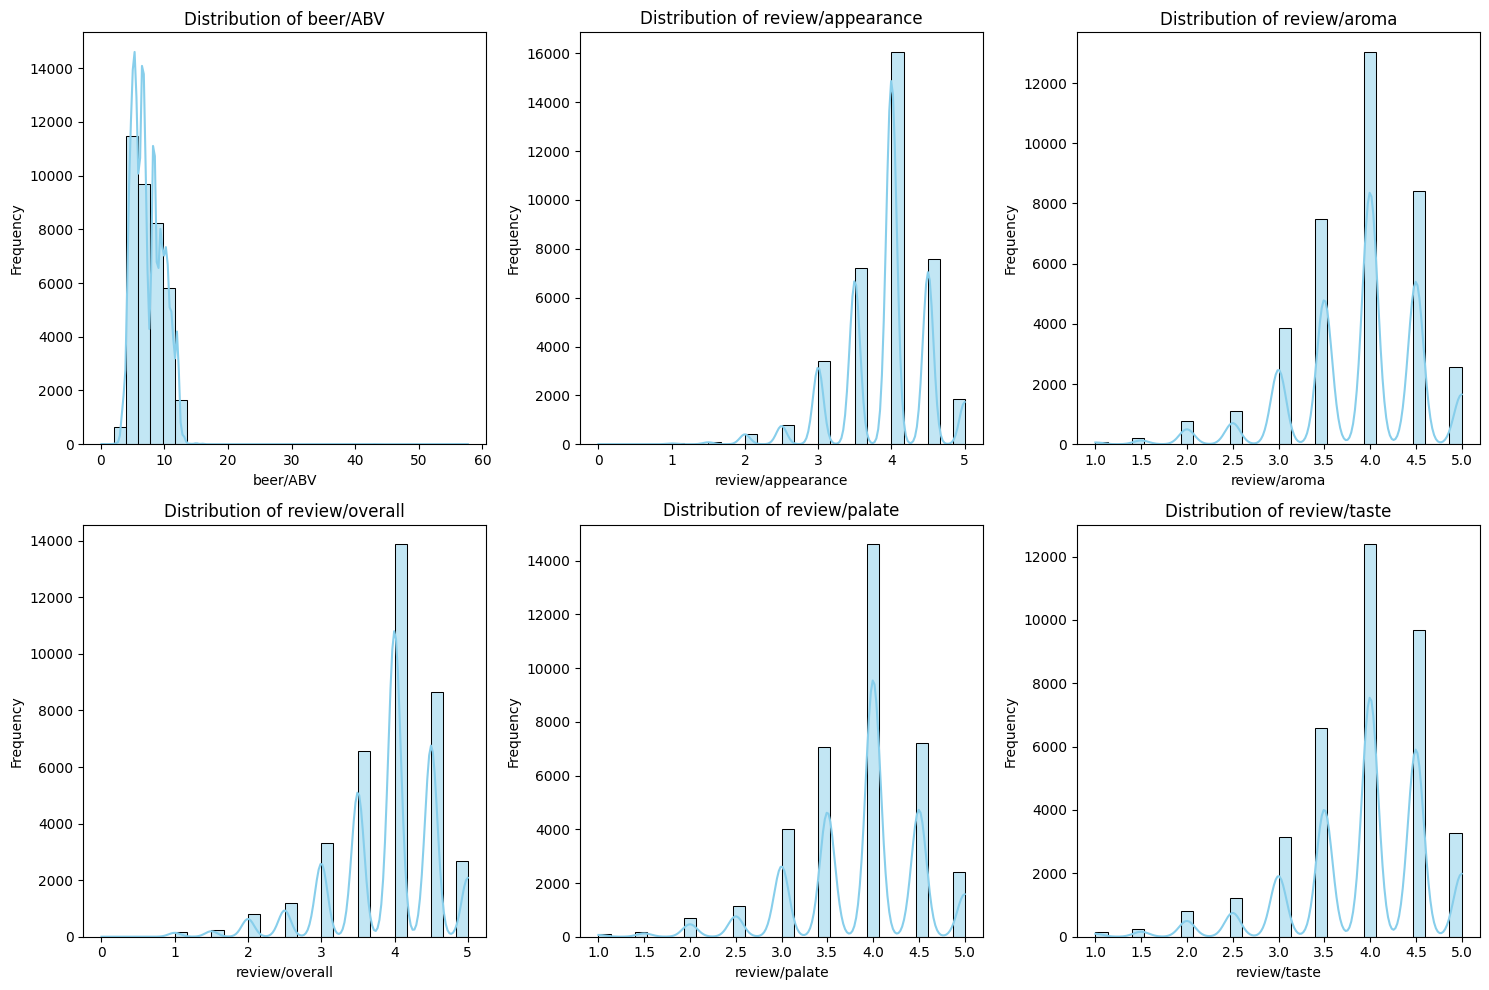

In [20]:
# Plot distributions of numeric variables

numeric_columns = ["beer/ABV", "review/appearance", "review/aroma",
                   "review/overall", "review/palate", "review/taste"]

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data_cleaned[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-21-3fe2dd83bba3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts.index, y=style_counts.values, palette="viridis")


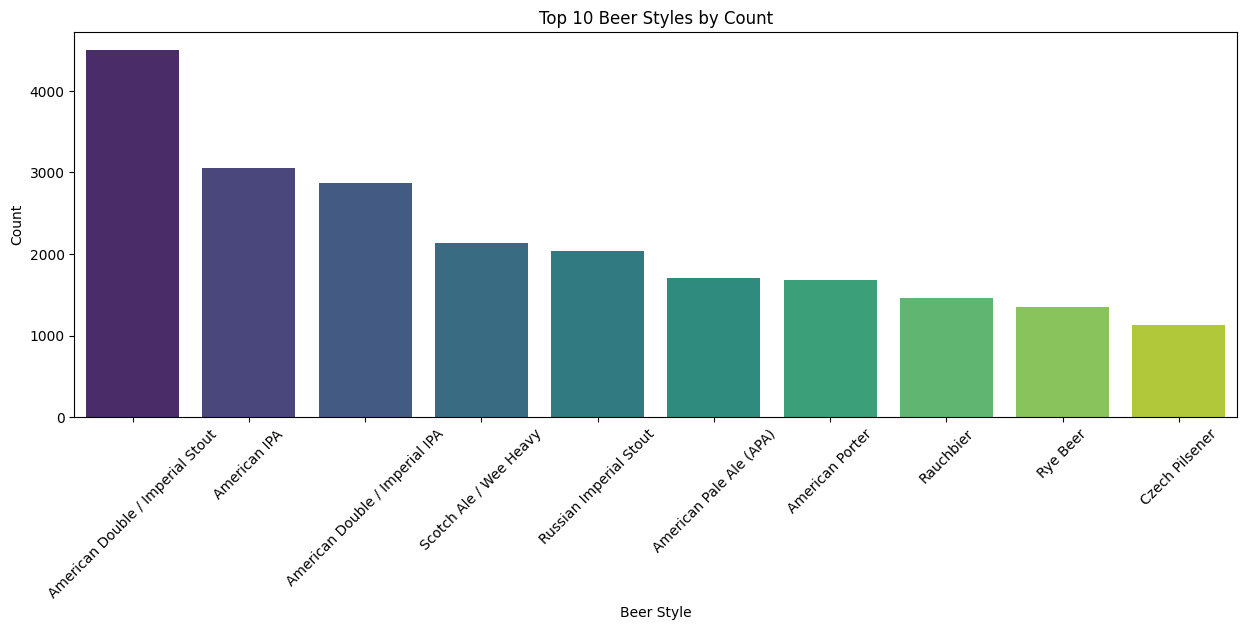

In [21]:
# Analyze beer styles
style_counts = data_cleaned["beer/style"].value_counts().head(10)  # Top 10 beer styles
avg_ratings_by_style = data_cleaned.groupby("beer/style")[
    ["review/overall", "review/taste", "review/aroma"]
].mean().sort_values("review/overall", ascending=False).head(10)

# Plot top 10 beer styles by count
plt.figure(figsize=(15, 5))
sns.barplot(x=style_counts.index, y=style_counts.values, palette="viridis")
plt.title("Top 10 Beer Styles by Count")
plt.xlabel("Beer Style")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


<ipython-input-22-1fc3ff0d693c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x="beer/style", y="review/overall", palette="Set2")


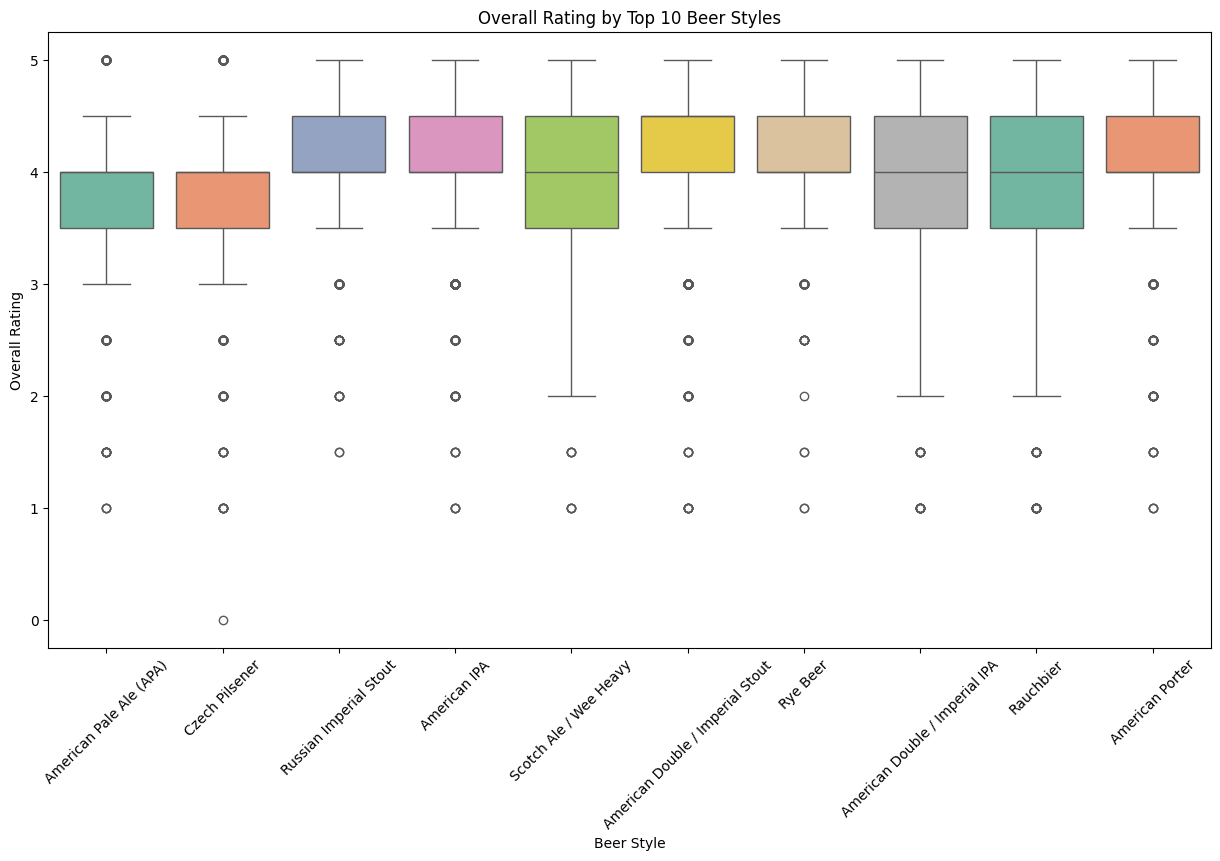

In [22]:
# Boxplot for overall rating by beer style (Top 10 styles)
top_styles = data_cleaned["beer/style"].value_counts().head(10).index
filtered_data = data_cleaned[data_cleaned["beer/style"].isin(top_styles)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=filtered_data, x="beer/style", y="review/overall", palette="Set2")
plt.title("Overall Rating by Top 10 Beer Styles")
plt.xlabel("Beer Style")
plt.ylabel("Overall Rating")
plt.xticks(rotation=45)
plt.show()

In [23]:
# Target and Features
X = df.drop(columns=['review/overall'])
y = df['review/overall']

In [24]:
# Text and Categorical Processing
text_feature = 'review/text'
categorical_features = ['beer/style']
numerical_features = ['beer/ABV', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste']

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Preprocessing Pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

In [28]:
# Model Pipelines
def build_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

In [29]:
# Define models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "SVR": SVR(),
    "Linear Regression": LinearRegression()
}

# Custom accuracy function for regression
def regression_accuracy(y_true, y_pred, tolerance=0.5):
    """
    Calculates the percentage of predictions that are within a certain tolerance of the true values.
    """
    correct = np.abs(y_true - y_pred) <= tolerance
    accuracy = np.mean(correct) * 100
    return accuracy
# Store results
results = []
# Train and evaluate each model
for name, model in models.items():
    print(f"\n{name} Results:")
    pipeline = build_pipeline(model)
    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    accuracy = regression_accuracy(y_test, preds, tolerance=0.5)  # Adjust tolerance if needed

    results.append({"Model": name, "RMSE": rmse, "R2": r2, "Accuracy": accuracy})
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")
    print(f"Accuracy: {accuracy:.2f}% (within ±0.5 tolerance)")



Random Forest Results:
RMSE: 0.4306787586529306
R² Score: 0.6229364433023308
Accuracy: 79.29% (within ±0.5 tolerance)

Gradient Boosting Results:
RMSE: 0.3937957646966758
R² Score: 0.684753889884373
Accuracy: 82.65% (within ±0.5 tolerance)

LightGBM Results:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 81
[LightGBM] [Info] Start training from score 3.888667


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


RMSE: 0.3942656019518297
R² Score: 0.6840012016236154
Accuracy: 82.77% (within ±0.5 tolerance)

SVR Results:
RMSE: 0.4004098283600299
R² Score: 0.674075421490259
Accuracy: 82.35% (within ±0.5 tolerance)

Linear Regression Results:
RMSE: 0.3968749864371384
R² Score: 0.6798045840363472
Accuracy: 82.33% (within ±0.5 tolerance)


<ipython-input-30-1b1f14a7a4d1>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, ci=None)


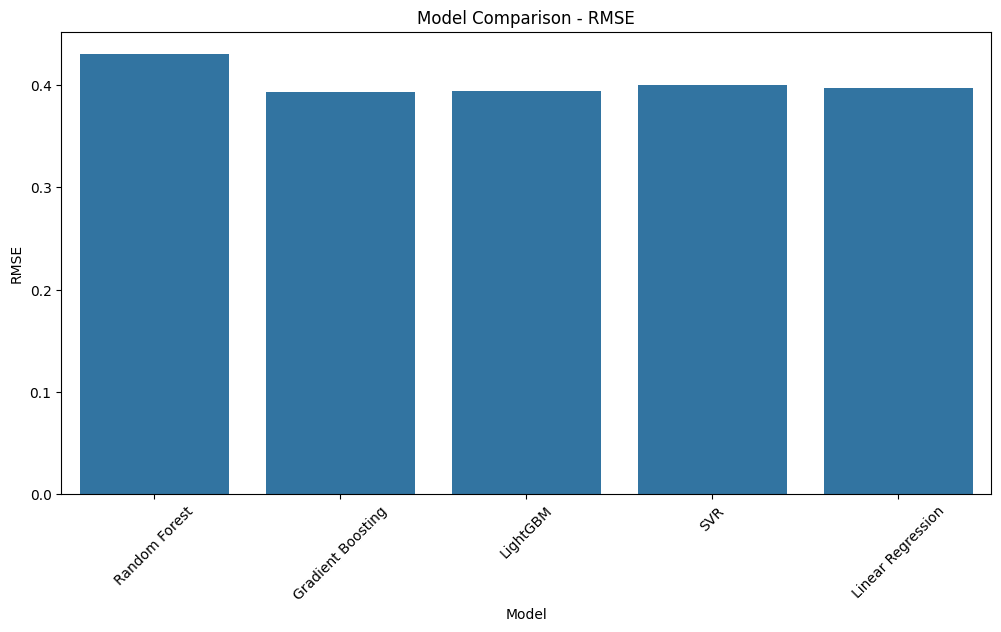

<ipython-input-30-1b1f14a7a4d1>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, ci=None)


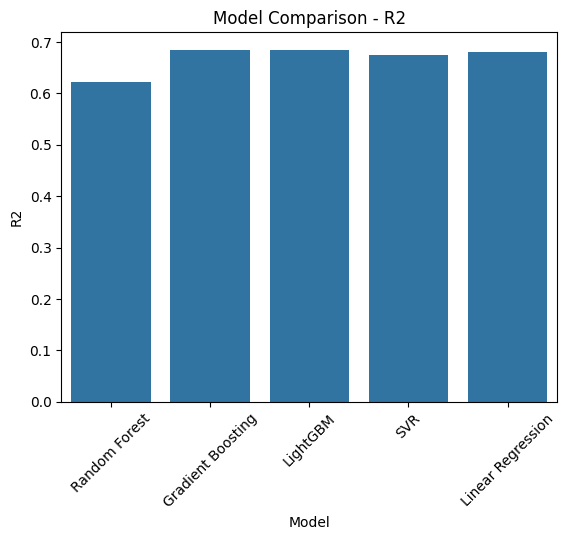

<ipython-input-30-1b1f14a7a4d1>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y=metric, data=results_df, ci=None)


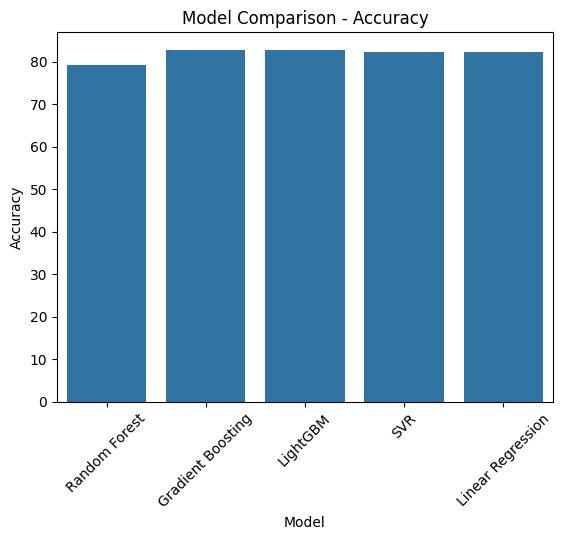

In [30]:
# Visualization: Model Comparison
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
for metric in ["RMSE", "R2", "Accuracy"]:
    sns.barplot(x="Model", y=metric, data=results_df, ci=None)
    plt.title(f"Model Comparison - {metric}")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.show()
